In [ ]:
# Draw histograms of labels across folds 

# 1. CSL
# 1.1. Biome distribution
# 1.2. DW band across 3 splits

# 2. SSL
# 2.1. Biome distribution
# 2.2. Spectral - 10 bands (reconstruction)
# 2.3. SIAM -97 bands

In [13]:
import os
import numpy as np
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import torch
import rasterio as rio
from torchvision import transforms
import csv
import matplotlib.pyplot as plt



In [3]:
# modifying class to have only one band in label

class SiamDW_DataClass(Dataset):
    def __init__(self, data_path, metadata, set, learn_type, process_level, input_type, lis_patch_ids = None, feat_transform=None, label_transform = None):
    # in metadata dataframe, select patches with set as train 
        self.data_path = data_path
        self.set = set
        self.process_level = process_level
        self.learn_type = learn_type
        self.input_type = input_type
        self.metadata = metadata
        self.feat_transform = feat_transform
        self.label_transform = label_transform

        # subset based on set (train/test) and learn_type (csl/ssl)
        self.metadata_set = self.metadata[(self.metadata['set']==self.set) & (self.metadata['learn_type']==self.learn_type)]
        
        # subset again if list of patch_ids is given - this will be used during training for implementing stratified kfold
        if lis_patch_ids is not None:
            self.metadata_set = self.metadata_set[self.metadata_set['patch_id'].isin(lis_patch_ids)]

    def __len__(self):
        return len(self.metadata_set)

    def __getitem__(self, idx):

        # Load label
        label_fname= (f"{self.process_level}_"
                f"{self.learn_type}_"
                f"{self.metadata_set.iloc[idx, 0]}_"
                f"label.tif")
        label_p = os.path.join(self.data_path, label_fname)
        with rio.open(label_p) as src:
            label = src.read().astype(np.int16)

        # Load feature (based on input type)
        if self.input_type == 's2':                 # multipsectral input
            feat_fname= (f"{self.process_level}_"
                        f"{self.learn_type}_"
                        f"{self.metadata_set.iloc[idx, 0]}_"
                        f"feats.tif")
            feat_p = os.path.join(self.data_path, feat_fname)
            with rio.open(feat_p) as src:
                feat = src.read().astype(np.int16)
       
        elif 'siam' in self.input_type:             # siam input
            feat = self.convert_to_rgb(label, self.input_type)

        # Convert to torch tensors of type float32
        feat = torch.from_numpy(feat).to(torch.float32)
        label = torch.from_numpy(label).to(torch.float32)

        # move up 255 to a value after max of the granularity, subtract 1 from last 4 bands i.e. siam bands of label to make it 0-indexed
        if self.learn_type == 'ssl':
            #set 255 to value after max value in the band
            label[1]=torch.where(label[1]==255, 19, label[1])
            label[2]=torch.where(label[2]==255, 34, label[2])
            label[3]=torch.where(label[3]==255, 49, label[3])
            label[4]=torch.where(label[4]==255, 97, label[4])
            label[1:] = label[1:] - 1
        
        if self.feat_transform is not None: 
            feat = self.feat_transform(feat)     
        if self.label_transform is not None:
            label = self.label_transform(label)    # for padding 

        return feat, label.long(), self.metadata_set.iloc[idx, 0] #get the patch id to save results
    
    def read_legend(self, legend_path):
        with open(legend_path, mode='r') as file:
            reader = csv.DictReader(file, delimiter=',')  
            rgb_dict = {}
            for row in reader:
                #print(row)
                value = int(row['value'])
                rgb = tuple(map(int, row['rgb'][1:-1].split(',')))  # Convert "(r, g, b)" string to tuple
                rgb_dict[value] = rgb
        return rgb_dict
    
    def convert_to_rgb(self, label, input_type):
        #path to legend csv
        file_name = 'lgd_' + input_type + '.csv'
        legend_path = os.path.split(os.path.split(self.data_path)[0])[0] # remove last two levels of path to get to the data folder
        legend_path = os.path.join(legend_path, 'legends',file_name)
        rgb_dict = self.read_legend(legend_path) # this returns a dictionary with class values as keys and rgb values as tuples
        rgb_image = np.zeros((3, label.shape[1], label.shape[2]), dtype=np.uint8)

        # band 0 is scl, band 1 in label is siam_18, band 2 is siam_33, band 3 is siam_48, band 4 is siam_96
        if input_type == 'siam_18':
            band = 1
        elif input_type == 'siam_33':
            band = 2
        elif input_type == 'siam_48':
            band = 3
        elif input_type == 'siam_96':
            band = 4
        
        # Create RGB image by assigning values to the image based on the tensor values of the siam band of interest
        for value, rgb in rgb_dict.items():
            rgb_image[0, label[band] == value] = rgb[0]
            rgb_image[1, label[band] == value] = rgb[1]
            rgb_image[2, label[band] == value] = rgb[2]

        return rgb_image


In [4]:
class NormalizeImage:

    def __init__(self, input_type):
        super(NormalizeImage, self).__init__()
        self.input_type = input_type
        
    def __call__(self, image):
        if self.input_type == 's2':
            return self.normalize_s2(image)
        elif 'siam' in self.input_type:
            return self.normalize_siam(image)
        
    def normalize_s2(self, image):
        # Normalize image to the 1st and 99th percentile
        num_bands, _, _ = image.shape
        flattened_image = image.view(num_bands, -1)

        # Calculate the 1st and 99th percentile along the band dimension
        min_percentiles = torch.kthvalue(flattened_image, int(flattened_image.size(1) * 0.01), dim=1).values
        max_percentiles = torch.kthvalue(flattened_image, int(flattened_image.size(1) * 0.99), dim=1).values

        # Reshape percentiles to have shape (num_bands, 1, 1). This is necessary for element-wise operations
        min_percentiles = min_percentiles[:, None, None]
        max_percentiles = max_percentiles[:, None, None]

        # Clip image values to the range defined by percentiles
        normalized_image = torch.clamp((image - min_percentiles) / (max_percentiles - min_percentiles), 0, 1)
        return normalized_image
    
    def normalize_siam(self, image):
        # divide all three bands by 255
        normalized_image = image/255.0
        return normalized_image

class Padding:
    def __init__(self, output_size=(512, 512)):
        self.output_size = output_size

    def __call__(self, image):
        _, h, w = image.shape
        new_h, new_w = self.output_size

        top_pad = (new_h - h) // 2
        bottom_pad = new_h - h - top_pad
        left_pad = (new_w - w) // 2
        right_pad = new_w - w - left_pad

        padded_image = torch.nn.functional.pad(image, (left_pad, right_pad, top_pad, bottom_pad))
        return padded_image


In [5]:
def prepare_trainval_loaders(input_dir, process_level, learn_type, input_type, batch_size,train_pids,val_pids):
    metadata = pd.read_csv(os.path.join(input_dir, 'meta_patches.csv'))
    train_data_path = os.path.join(input_dir, process_level, 'train')

    feat_transform = transforms.Compose([NormalizeImage(input_type=input_type), Padding((512, 512))])
    label_transform = transforms.Compose([Padding((512, 512))])

    args={'data_path':train_data_path, 'metadata':metadata, 'set':'train', 'learn_type':learn_type, 'process_level':process_level, 
          'input_type':input_type, 'feat_transform':feat_transform, 'label_transform':label_transform}
    
    train_dataset = SiamDW_DataClass(lis_patch_ids=train_pids, **args)
    val_dataset = SiamDW_DataClass(lis_patch_ids=val_pids, **args)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, drop_last=True, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
    return train_loader, val_loader

def generate_stratified_folds(input_dir, process_level, learn_type, input_type, batch_size, n_splits=3):
    # look through input_dir and look for test_files_{i}.pkl files
    path = r'D:\Projects_Github\semantic-enrichment-for-semantic-image-segmentation\split_folds'
    for i in range(n_splits):
        train_pids = pd.read_pickle(os.path.join(path, f'{learn_type}_train_files_{i}.pkl'))
        val_pids = pd.read_pickle(os.path.join(path, f'{learn_type}_val_files_{i}.pkl'))
        print(f'Fold {i} - Train: {len(train_pids)}, Val: {len(val_pids)}')
        train_loader, val_loader = prepare_trainval_loaders(input_dir, process_level, learn_type, input_type, batch_size,train_pids,val_pids)
        yield train_loader, val_loader

def prepare_test_loader(input_dir, process_level, learn_type, input_type, batch_size):
    
    metadata = pd.read_csv(os.path.join(input_dir, 'meta_patches.csv'))
    test_data_path = os.path.join(input_dir, process_level, 'test')

    feat_transform = transforms.Compose([NormalizeImage(input_type=input_type), Padding((512, 512))])
    label_transform = transforms.Compose([Padding((512, 512))])

    args={'data_path':test_data_path, 'metadata':metadata, 'set':'test', 'learn_type':learn_type, 'process_level':process_level, 
          'input_type':input_type, 'feat_transform':feat_transform, 'label_transform':label_transform}
    
    test_dataset = SiamDW_DataClass(**args)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, drop_last=True, shuffle=False)
    return test_loader


#### 1. CSL Histograms

In [120]:
input_dir = 'E:\Thesis\data\small'
out_dir = r'E:\Thesis\outputs\00_charts'
process_level = 'l1c'
input_type = 's2'
batch_size = 16

#### 1.1. Biome histogram

In [92]:
# Biome distribution across folds
splits_path = r'D:\Projects_Github\semantic-enrichment-for-semantic-image-segmentation\split_folds'
metadata = pd.read_csv(os.path.join(input_dir, 'meta_patches.csv'))

train_df = pd.DataFrame(columns=['fold', 'biome_id', 'count'])
val_df = pd.DataFrame(columns=['fold', 'biome_id', 'count'])
# load the pickle files in a loop
for i in range(3):
    train_pids = pd.read_pickle(os.path.join(splits_path, f'csl_train_files_{i}.pkl'))
    val_pids = pd.read_pickle(os.path.join(splits_path, f'csl_val_files_{i}.pkl'))

    train_metadata = metadata[metadata['patch_id'].isin(train_pids)]
    val_metadata = metadata[metadata['patch_id'].isin(val_pids)]

    #print(train_metadata['biome_id'].value_counts().reset_index())
    train_biomes = train_metadata['biome_id'].value_counts(normalize=False).reset_index().rename(columns={'index':'biome_id', 'biome_id':'count'})
    val_biomes = val_metadata['biome_id'].value_counts(normalize=False).reset_index().rename(columns={'index':'biome_id', 'biome_id':'count'})

    
    train_biomes['fold'] = i
    val_biomes['fold'] = i

    train_df = pd.concat([train_df, train_biomes], axis=0)
    val_df = pd.concat([val_df, val_biomes], axis=0)

In [38]:
# sum of counts in fold 1
print(train_df[train_df['fold']==0]['pc'].sum())
print(len(train_df)) , print(len(val_df))

0.9999999999999999


In [125]:
biome_names_IDs = metadata.groupby(['biome_id', 'biome_str']).size().reset_index().rename(columns={0:'count'})
# pretty table view of biome names and IDs
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ['Biome ID', 'Biome Name']
for i in range(len(biome_names_IDs)):
    x.add_row([int(biome_names_IDs.iloc[i, 0]), biome_names_IDs.iloc[i, 1]])
print(x)


+----------+----------------------------------------------------------+
| Biome ID |                        Biome Name                        |
+----------+----------------------------------------------------------+
|    1     |      Tropical & Subtropical Moist Broadleaf Forests      |
|    2     |       Tropical & Subtropical Dry Broadleaf Forests       |
|    3     |        Tropical & Subtropical Coniferous Forests         |
|    4     |           Temperate Broadleaf & Mixed Forests            |
|    5     |                Temperate Conifer Forests                 |
|    6     |                   Boreal Forests/Taiga                   |
|    7     | Tropical & Subtropical Grasslands, Savannas & Shrublands |
|    8     |       Temperate Grasslands, Savannas & Shrublands        |
|    9     |              Flooded Grasslands & Savannas               |
|    10    |             Montane Grasslands & Shrublands              |
|    11    |                          Tundra                    

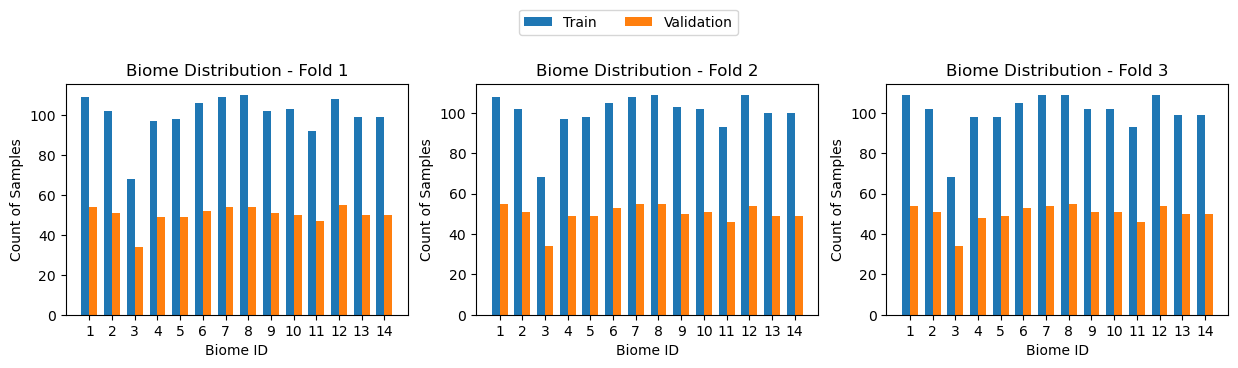

In [90]:
import matplotlib.pyplot as plt

train_grouped = train_df.groupby(['fold', 'biome_id']).sum().reset_index()
val_grouped = val_df.groupby(['fold', 'biome_id']).sum().reset_index()

# Get unique biome_ids
biome_ids = np.unique(train_grouped['biome_id'])

# Set width of bars
bar_width = 0.35

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for fold in range(3):
    
    train_data = train_grouped[train_grouped['fold'] == fold]
    val_data = val_grouped[val_grouped['fold'] == fold]
    
    # Get index for each biome_id
    train_index = np.arange(len(train_data))
    val_index = [x + bar_width for x in train_index]

        # Plot bars
    axes[fold].bar(train_index, train_data['count'], bar_width, label='Train')
    axes[fold].bar(val_index, val_data['count'], bar_width, label='Validation')
    
    # Set labels, title, and legend
    axes[fold].set_xlabel('Biome ID')
    axes[fold].set_ylabel('Count of Samples')
    axes[fold].set_title(f'Biome Distribution - Fold {fold+1}')
    axes[fold].set_xticks([x + bar_width / 2 for x in train_index])
    axes[fold].set_xticklabels([int(i) for i in biome_ids])
    #axes[fold].legend()

# common legend for all subplots
fig.legend(['Train', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

#     plt.tight_layout()
#     plt.savefig(os.path.join(out_path, 'csl_biome_dist.png'), dpi=300,  pad_inches=0.2, bbox_inches='tight')
#     plt.close()
    


##### 1.2. Dynamic World class histogram

In [113]:

base_args = {'input_dir':input_dir, 'process_level':process_level, 'learn_type':'csl', 
                      'input_type':input_type, 'batch_size':batch_size}

csl_generator = generate_stratified_folds(**base_args)

In [114]:
# histogram 
num_classes = 11
num_splits = 3
train_hist = np.zeros((num_classes, num_splits))
val_hist = np.zeros((num_classes, num_splits))

for i in range(num_splits):
    train_loader, val_loader = next(csl_generator)
    for k,batch in enumerate(train_loader):
        _, labels, _ = batch
        #print(labels.shape)
        for j in range(num_classes):
            train_hist[j, i] += torch.sum(labels[:,5,:,:] == j).item()
        print(f'Batch Train {k} done')
    print(f'Fold Train {i} done')
    
    for k,batch in enumerate(val_loader):
        _, labels, _ = batch
        for j in range(num_classes):
            val_hist[j, i] += torch.sum(labels[:,5,:,:] == j).item()
        print(f'Batch Val {k} done')
    print(f'Fold Val {i} done')


Fold 0 - Train: 1402, Val: 700
Batch Train 0 done
Batch Train 1 done
Batch Train 2 done
Batch Train 3 done
Batch Train 4 done
Batch Train 5 done
Batch Train 6 done
Batch Train 7 done
Batch Train 8 done
Batch Train 9 done
Batch Train 10 done
Batch Train 11 done
Batch Train 12 done
Batch Train 13 done
Batch Train 14 done
Batch Train 15 done
Batch Train 16 done
Batch Train 17 done
Batch Train 18 done
Batch Train 19 done
Batch Train 20 done
Batch Train 21 done
Batch Train 22 done
Batch Train 23 done
Batch Train 24 done
Batch Train 25 done
Batch Train 26 done
Batch Train 27 done
Batch Train 28 done
Batch Train 29 done
Batch Train 30 done
Batch Train 31 done
Batch Train 32 done
Batch Train 33 done
Batch Train 34 done
Batch Train 35 done
Batch Train 36 done
Batch Train 37 done
Batch Train 38 done
Batch Train 39 done
Batch Train 40 done
Batch Train 41 done
Batch Train 42 done
Batch Train 43 done
Batch Train 44 done
Batch Train 45 done
Batch Train 46 done
Batch Train 47 done
Batch Train 48 done

In [121]:
# save the histograms
np.save(os.path.join(out_dir, 'train_hist.npy'), train_hist)
np.save(os.path.join(out_dir, 'val_hist.npy'), val_hist)

In [130]:
# load the histograms
train_hist = np.load(os.path.join(out_dir, 'train_hist.npy'))
val_hist = np.load(os.path.join(out_dir, 'val_hist.npy'))

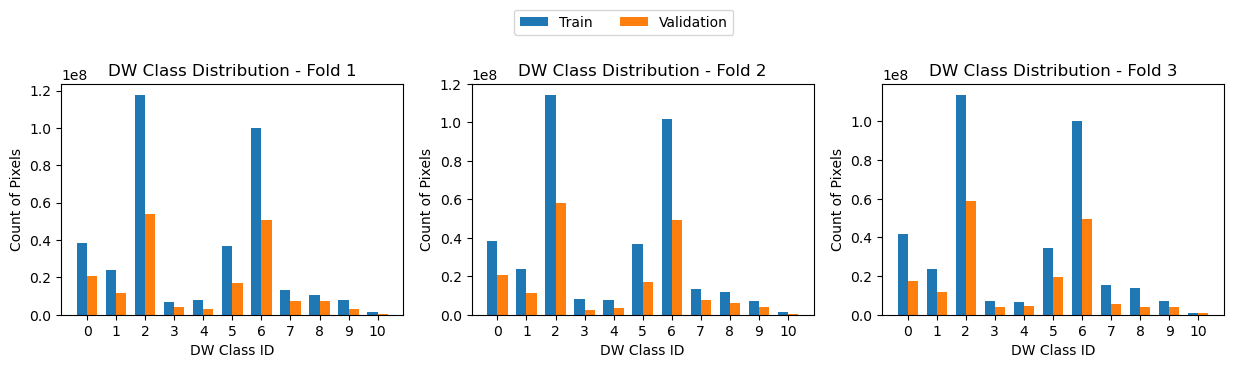

In [131]:
# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
bar_width = 0.35
for fold in range(3):

    train_index = np.arange(num_classes)
    val_index = [x + bar_width for x in train_index]

    axes[fold].bar(train_index, train_hist[:, fold], bar_width, label='Train')
    axes[fold].bar(val_index, val_hist[:, fold], bar_width, label='Validation')

    axes[fold].set_xlabel('DW Class ID')
    axes[fold].set_ylabel('Count of Pixels')
    axes[fold].set_title(f'DW Class Distribution - Fold {fold+1}')
    axes[fold].set_xticks([x + bar_width / 2 for x in train_index])
    axes[fold].set_xticklabels([int(i) for i in range(num_classes)])
    #axes[fold].legend()

fig.legend(['Train', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()
#     plt.tight_layout()
#     plt.savefig(os.path.join(out_path, 'csl_dw_dist.png'), dpi=300,  pad_inches=0.2, bbox_inches='tight')
#     plt.close()

In [115]:
train_hist

array([[3.85976940e+07, 3.85357690e+07, 4.15666570e+07],
       [2.37642800e+07, 2.36508000e+07, 2.34185720e+07],
       [1.17797756e+08, 1.14374516e+08, 1.13813725e+08],
       [6.81187000e+06, 8.15081100e+06, 7.03822800e+06],
       [7.86610400e+06, 7.56849800e+06, 6.79269100e+06],
       [3.66994120e+07, 3.68051050e+07, 3.45387250e+07],
       [1.00215100e+08, 1.01856804e+08, 1.00460608e+08],
       [1.32429620e+07, 1.33438770e+07, 1.54558160e+07],
       [1.04501510e+07, 1.20308580e+07, 1.37932340e+07],
       [8.05286500e+06, 7.19705000e+06, 6.91602600e+06],
       [1.40625400e+06, 1.39036000e+06, 1.11016600e+06]])

In [116]:
val_hist

array([[20612302., 20730281., 17625604.],
       [11670593., 11386485., 11592650.],
       [54023713., 57826025., 58992553.],
       [ 4244330.,  2519950.,  4106209.],
       [ 3186417.,  3538596.,  4322234.],
       [16991499., 16807726., 19309221.],
       [50921343., 49386217., 49747346.],
       [ 7608221.,  7585978.,  5494641.],
       [ 7599410.,  6116552.,  4146134.],
       [ 2957374.,  3894232.,  4175256.],
       [  539870.,   563030.,   843224.]])

In [129]:
from prettytable import PrettyTable

# load legend csv
file_name = 'E:\Thesis\others\legends\lgd_dw.csv'
df = pd.read_csv(file_name) 
# pretty table view of value and label
x = PrettyTable()
x.field_names = ['Value', 'Label']
for i in range(len(df)):
    x.add_row([int(df.iloc[i, 0]), df.iloc[i, 2]])
print(x)


+-------+-------------------------+
| Value |          Label          |
+-------+-------------------------+
|   0   | No data (left unmarked) |
|   1   |          Water          |
|   2   |          Trees          |
|   3   |          Grass          |
|   4   |    Flooded Vegetation   |
|   5   |          Crops          |
|   6   |          Scrub          |
|   7   |        Built Area       |
|   8   |       Bare Ground       |
|   9   |         Snow/Ice        |
|   10  |          Cloud          |
+-------+-------------------------+


#### 2. SSL Histograms

#### 2.1. Biome histogram

In [6]:
input_dir = 'E:\Thesis\data\small'
out_dir = r'E:\Thesis\outputs\00_charts'
process_level = 'l1c'
input_type = 's2'
batch_size = 16

In [145]:
# Biome distribution across folds
splits_path = r'D:\Projects_Github\semantic-enrichment-for-semantic-image-segmentation\split_folds'
metadata = pd.read_csv(os.path.join(input_dir, 'meta_patches.csv'))

train_df = pd.DataFrame(columns=['fold', 'biome_id', 'count'])
val_df = pd.DataFrame(columns=['fold', 'biome_id', 'count'])
# load the pickle files in a loop
for i in range(3):
    train_pids = pd.read_pickle(os.path.join(splits_path, f'ssl_train_files_{i}.pkl'))
    val_pids = pd.read_pickle(os.path.join(splits_path, f'ssl_val_files_{i}.pkl'))

    train_metadata = metadata[metadata['patch_id'].isin(train_pids)]
    val_metadata = metadata[metadata['patch_id'].isin(val_pids)]
    print(f'Fold {i} - Train: {len(train_metadata)}, Val: {len(val_metadata)}')

    #print(train_metadata['biome_id'].value_counts().reset_index())
    train_biomes = train_metadata['biome_id'].value_counts(dropna=False, normalize=False).reset_index().rename(columns={'index':'biome_id', 'biome_id':'count'})
    val_biomes = val_metadata['biome_id'].value_counts(dropna=False, normalize=False).reset_index().rename(columns={'index':'biome_id', 'biome_id':'count'})

    train_biomes['fold'] = i
    val_biomes['fold'] = i

    train_df = pd.concat([train_df, train_biomes], axis=0)
    val_df = pd.concat([val_df, val_biomes], axis=0)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)

Fold 0 - Train: 2401, Val: 1200
Fold 1 - Train: 2401, Val: 1200
Fold 2 - Train: 2401, Val: 1200


In [158]:
from prettytable import PrettyTable

biome_names_IDs = metadata.groupby(['biome_id', 'biome_str'], dropna=False).size().reset_index().rename(columns={0:'count'})
# pretty table view of biome names and IDs
x = PrettyTable()
x.field_names = ['Biome ID', 'Biome Name']
for i in range(len(biome_names_IDs)):
    if pd.isna(biome_names_IDs.iloc[i, 0]):
        id = 'NaN'
    else:
        id= int(biome_names_IDs.iloc[i, 0])
        
    if pd.isna(biome_names_IDs.iloc[i, 1]):
        continue
    x.add_row([id, biome_names_IDs.iloc[i, 1]])
print(x)


+----------+----------------------------------------------------------+
| Biome ID |                        Biome Name                        |
+----------+----------------------------------------------------------+
|    1     |      Tropical & Subtropical Moist Broadleaf Forests      |
|    2     |       Tropical & Subtropical Dry Broadleaf Forests       |
|    3     |        Tropical & Subtropical Coniferous Forests         |
|    4     |           Temperate Broadleaf & Mixed Forests            |
|    5     |                Temperate Conifer Forests                 |
|    6     |                   Boreal Forests/Taiga                   |
|    7     | Tropical & Subtropical Grasslands, Savannas & Shrublands |
|    8     |       Temperate Grasslands, Savannas & Shrublands        |
|    9     |              Flooded Grasslands & Savannas               |
|    10    |             Montane Grasslands & Shrublands              |
|    11    |                          Tundra                    

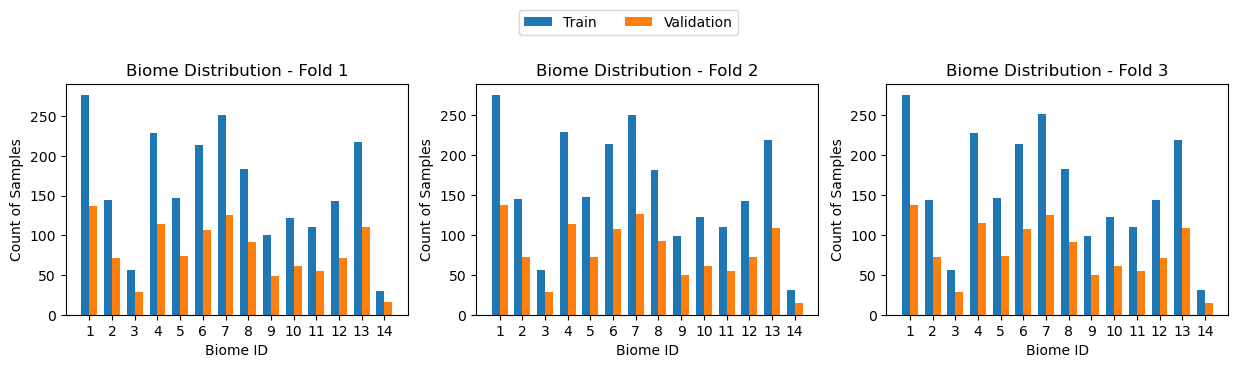

In [159]:

train_grouped = train_df.groupby(['fold', 'biome_id']).sum().reset_index()
val_grouped = val_df.groupby(['fold', 'biome_id']).sum().reset_index()

# Get unique biome_ids
biome_ids = np.unique(train_grouped['biome_id'])

# Set width of bars
bar_width = 0.35

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for fold in range(3):
    
    train_data = train_grouped[train_grouped['fold'] == fold]
    val_data = val_grouped[val_grouped['fold'] == fold]
    
    # Get index for each biome_id
    train_index = np.arange(len(train_data))
    val_index = [x + bar_width for x in train_index]

        # Plot bars
    axes[fold].bar(train_index, train_data['count'], bar_width, label='Train')
    axes[fold].bar(val_index, val_data['count'], bar_width, label='Validation')
    
    # Set labels, title, and legend
    axes[fold].set_xlabel('Biome ID')
    axes[fold].set_ylabel('Count of Samples')
    axes[fold].set_title(f'Biome Distribution - Fold {fold+1}')
    axes[fold].set_xticks([x + bar_width / 2 for x in train_index])
    axes[fold].set_xticklabels([int(i) for i in biome_ids])
    #axes[fold].legend()

# common legend for all subplots
fig.legend(['Train', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, 1.15), ncol=2)
plt.show()

#     plt.tight_layout()
#     plt.savefig(os.path.join(out_path, 'csl_biome_dist.png'), dpi=300,  pad_inches=0.2, bbox_inches='tight')
#     plt.close()
    


#### 2.2. SIAM histogram

In [7]:
base_args_ssl = {'input_dir':input_dir, 'process_level':process_level, 'learn_type':'ssl',
                        'input_type':'s2', 'batch_size':batch_size}
    
generator_ssl = generate_stratified_folds(**base_args_ssl)

In [8]:
# histogram of labels
num_classes = 97
num_splits = 3
train_hist = np.zeros((num_classes, num_splits))
val_hist = np.zeros((num_classes, num_splits))

for i in range(num_splits):
    train_loader, val_loader = next(generator_ssl)
    for k,batch in enumerate(train_loader):
        _, labels, _ = batch
        for j in range(num_classes):
            train_hist[j, i] += torch.sum(labels[:,4,:,:] == j).item()
        print(f'Batch Train {k} done')
    print(f'Fold Train {i} done')
    
    for k,batch in enumerate(val_loader):
        _, labels, _ = batch
        for j in range(num_classes):
            val_hist[j, i] += torch.sum(labels[:,4,:,:] == j).item()
        print(f'Batch Val {k} done')
    print(f'Fold Val {i} done')

Fold 0 - Train: 2401, Val: 1200
Batch Train 0 done
Batch Train 1 done
Batch Train 2 done
Batch Train 3 done
Batch Train 4 done
Batch Train 5 done
Batch Train 6 done
Batch Train 7 done
Batch Train 8 done
Batch Train 9 done
Batch Train 10 done
Batch Train 11 done
Batch Train 12 done
Batch Train 13 done
Batch Train 14 done
Batch Train 15 done
Batch Train 16 done
Batch Train 17 done
Batch Train 18 done
Batch Train 19 done
Batch Train 20 done
Batch Train 21 done
Batch Train 22 done
Batch Train 23 done
Batch Train 24 done
Batch Train 25 done
Batch Train 26 done
Batch Train 27 done
Batch Train 28 done
Batch Train 29 done
Batch Train 30 done
Batch Train 31 done
Batch Train 32 done
Batch Train 33 done
Batch Train 34 done
Batch Train 35 done
Batch Train 36 done
Batch Train 37 done
Batch Train 38 done
Batch Train 39 done
Batch Train 40 done
Batch Train 41 done
Batch Train 42 done
Batch Train 43 done
Batch Train 44 done
Batch Train 45 done
Batch Train 46 done
Batch Train 47 done
Batch Train 48 don

In [9]:
# save the histograms
np.save(os.path.join(out_dir, 'train_hist_siam_ssl.npy'), train_hist)
np.save(os.path.join(out_dir, 'val_hist_siam_ssl.npy'), val_hist)

In [10]:
#load
train_hist = np.load(os.path.join(out_dir, 'train_hist_siam_ssl.npy'))
val_hist = np.load(os.path.join(out_dir, 'val_hist_siam_ssl.npy'))

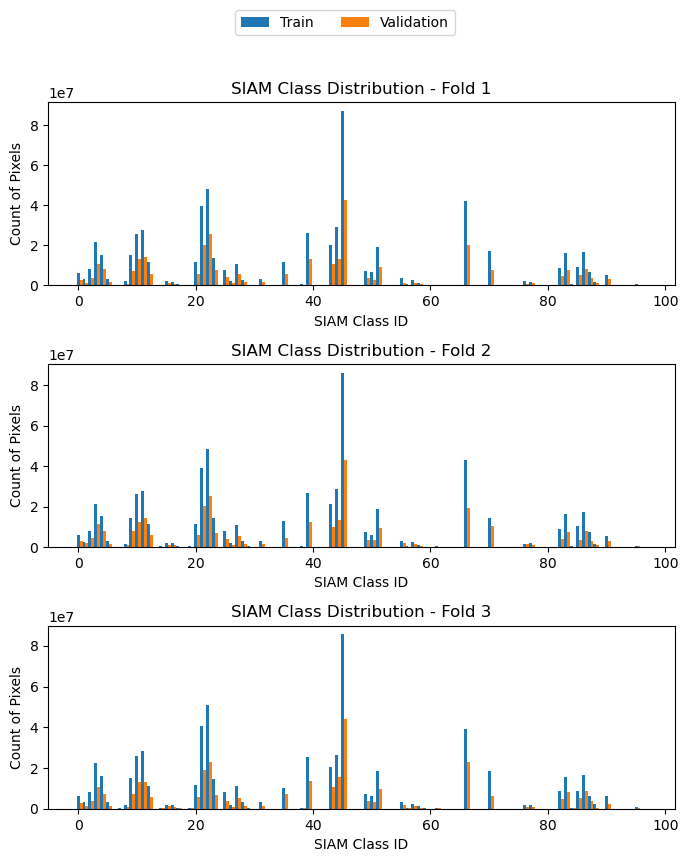

In [43]:
# Plotting
# kde plot for the histograms
import seaborn as sns
fig, axes = plt.subplots(3, 1, figsize=(7, 8))
bar_width = 0.5
for fold in range(3):
    train_index = np.arange(num_classes)
    val_index = [x + bar_width for x in train_index]

    axes[fold].bar(train_index, train_hist[:, fold], bar_width, label='Train')
    axes[fold].bar(val_index, val_hist[:, fold], bar_width, label='Validation')

    axes[fold].set_xlabel('SIAM Class ID')
    axes[fold].set_ylabel('Count of Pixels')
    axes[fold].set_title(f'SIAM Class Distribution - Fold {fold+1}')
    #axes[fold].set_xticks([x + bar_width / 2 for x in train_index])
    #axes[fold].set_xticklabels([int(i) for i in range(num_classes)])
    #axes[fold].legend()

fig.legend(['Train', 'Validation'], loc='upper center', bbox_to_anchor=(0.5, 1.08), ncol=2)
plt.tight_layout()
plt.show()
#     plt.tight_layout()
#     plt.savefig(os.path.join(out_path, 'csl_dw_dist.png'), dpi=300,  pad_inches=0.2, bbox_inches='tight')
#     plt.close()

#### 2.3. MS Bands histogram

In [49]:
base_args_ssl = {'input_dir':input_dir, 'process_level':process_level, 'learn_type':'ssl',
                        'input_type':'s2', 'batch_size':batch_size}
    
generator_ssl = generate_stratified_folds(**base_args_ssl)

In [50]:
# histogram of multispectral bands in the feature 
num_bands = 10
num_splits = 3
bins = 200

train_hist = np.zeros((num_bands, num_splits, bins))
val_hist = np.zeros((num_bands, num_splits, bins))

for i in range(num_splits):
    train_loader, val_loader = next(generator_ssl)
    for k,batch in enumerate(train_loader):
        feats, _, _ = batch
        #print(feats.shape)
        for j in range(num_bands):
            train_hist[j, i], _ = np.histogram(feats[:,j,:,:].flatten(), bins=bins, range=(0, 1))
            
        print(f'Batch Train {k}/{len(train_loader)} done')
    
    print(f'Fold Train {i} done')
    
    for k,batch in enumerate(val_loader):
        feats, _, _ = batch
        for j in range(num_bands):
            val_hist[j, i], _ = np.histogram(feats[:,j,:,:].flatten(), bins=bins, range=(0, 1))
            
        print(f'Batch Val {k}/{len(val_loader)} done')
    
    print(f'Fold Val {i} done')

# save the histograms
np.save(os.path.join(out_dir, 'train_hist_s2_ssl.npy'), train_hist)
np.save(os.path.join(out_dir, 'val_hist_s2_ssl.npy'), val_hist)

Fold 0 - Train: 2401, Val: 1200
Batch Train 0/150 done
Batch Train 1/150 done
Batch Train 2/150 done
Batch Train 3/150 done
Batch Train 4/150 done
Batch Train 5/150 done
Batch Train 6/150 done
Batch Train 7/150 done
Batch Train 8/150 done
Batch Train 9/150 done
Batch Train 10/150 done
Batch Train 11/150 done
Batch Train 12/150 done
Batch Train 13/150 done
Batch Train 14/150 done
Batch Train 15/150 done
Batch Train 16/150 done
Batch Train 17/150 done
Batch Train 18/150 done
Batch Train 19/150 done
Batch Train 20/150 done
Batch Train 21/150 done
Batch Train 22/150 done
Batch Train 23/150 done
Batch Train 24/150 done
Batch Train 25/150 done
Batch Train 26/150 done
Batch Train 27/150 done
Batch Train 28/150 done
Batch Train 29/150 done
Batch Train 30/150 done
Batch Train 31/150 done
Batch Train 32/150 done
Batch Train 33/150 done
Batch Train 34/150 done
Batch Train 35/150 done
Batch Train 36/150 done
Batch Train 37/150 done
Batch Train 38/150 done
Batch Train 39/150 done
Batch Train 40/150

In [53]:
train_hist.shape

(10, 3, 200)

In [ ]:
# Load histogram data
train_hist = np.load(os.path.join(out_dir, 'train_hist_s2_ssl.npy'))
val_hist = np.load(os.path.join(out_dir, 'val_hist_s2_ssl.npy'))

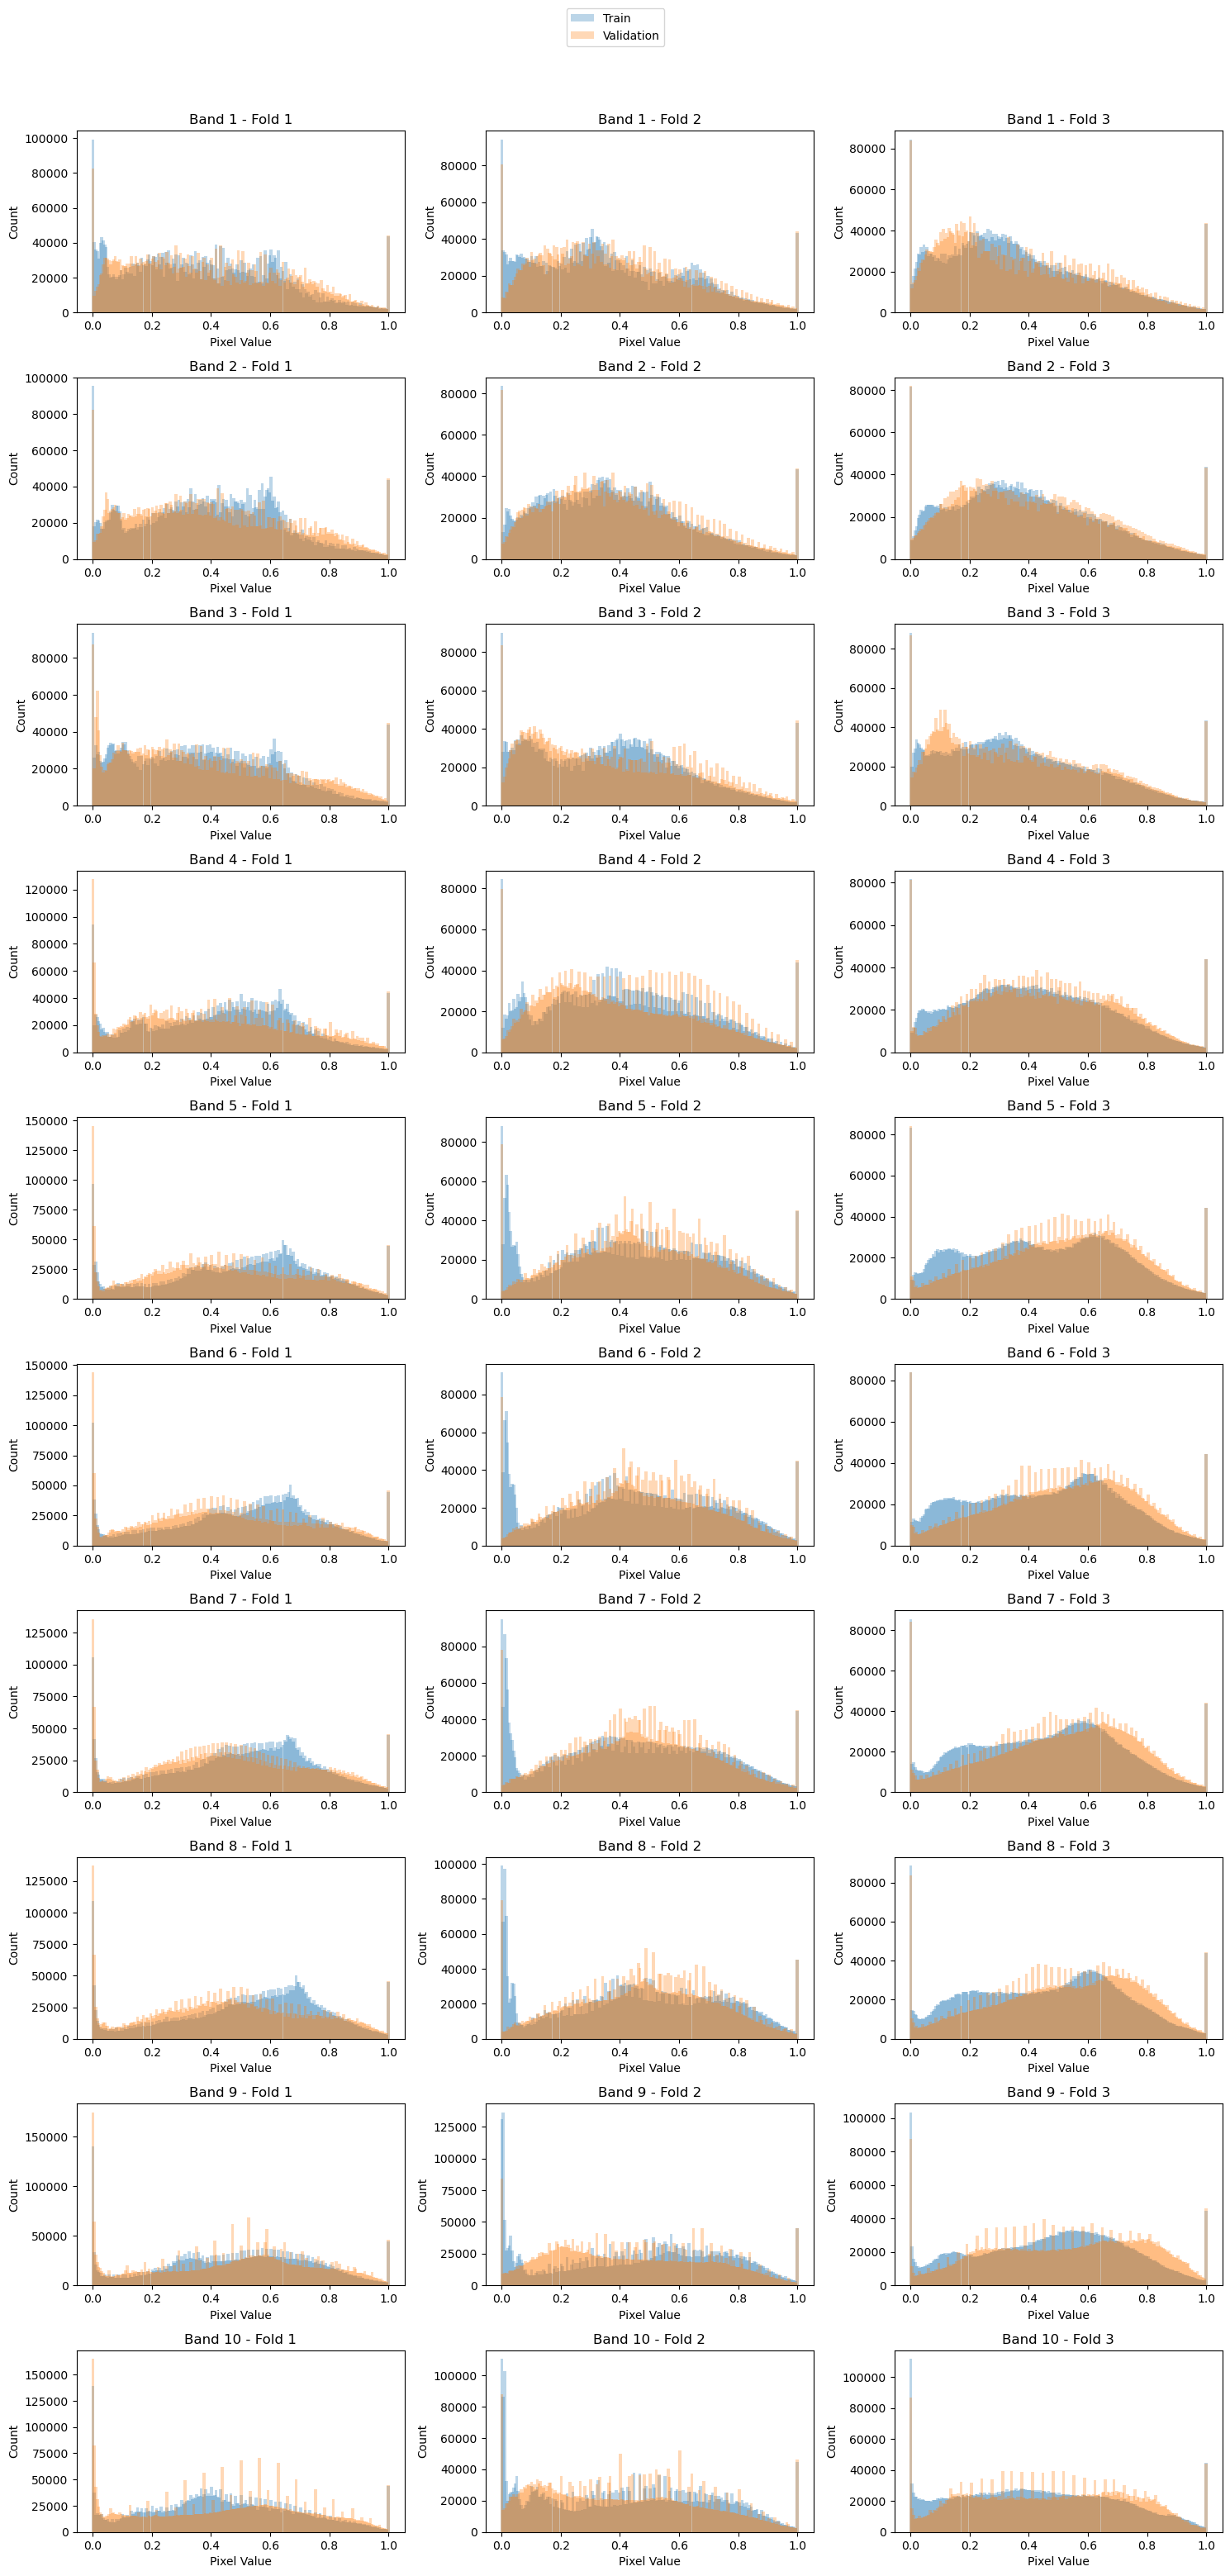

In [72]:
# Get number of bands, splits, and bins
num_bands = train_hist.shape[0]
num_splits = train_hist.shape[1]
bins = train_hist.shape[2]

# Plotting
fig, axes = plt.subplots(num_bands, num_splits, figsize=(15, 3*num_bands))
bar_width = 0.01
for i in range(num_bands):
    for j in range(num_splits):
        train_index = np.linspace(0, 1, bins)
        val_index = np.linspace(0, 1, bins)

        # axes[i, j].plot(train_index, train_hist[i, j], label='Train', alpha=)
        # axes[i, j].plot(val_index, val_hist[i, j], label='Validation')
        axes[i,j].bar(train_index, train_hist[i,j], bar_width, alpha = 0.3)
        axes[i,j].bar(val_index, val_hist[i,j], bar_width, alpha = 0.3)

        # axes[i,j].hist(train_hist[i,j], bins=bins, range=(0, 1), alpha=0.5, label='Train')
        # axes[i,j].hist(val_hist[i,j], bins= bins, range=(0,1), alpha =0.5, label = 'Validation')

        axes[i, j].set_xlabel('Pixel Value')
        axes[i, j].set_ylabel('Count')
        axes[i, j].set_title(f'Band {i+1} - Fold {j+1}')
fig.legend(['Train', 'Validation'],loc='upper center', bbox_to_anchor=(0.5, 1.04))
plt.tight_layout()
plt.show()
